<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/TransferLearning_imagewoof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 転移学習
ResNet をバックボーンネットワークとして，ImageWoof データセットを分類すべく，最終層のみを差し替える。

## 必要なライブラリのインポート

In [1]:
# 必要なライブラリのインポート ＆ デバイスの設定
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import requests
import tarfile

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


## ImageWoof データセットの属性をまとめる
後々，あちこちで参照するため，データセットの属性をまとめておく。

In [2]:
# データセットの属性
IMAGEWOOF_ATTRIBUTES = {
    'name': 'Imagewoof (160px)',
    'url': 'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz',
    'classes': ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle',
                'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo',
                'Golden retriever', 'Old English sheepdog'],
    'num_classes': 10,
    'resolution': '160x160'
}

## データをダウンロードするための関数

In [3]:
# データ・ダウンロードのためのヘルパー関数
def download_and_extract_dataset():
    """
    データセットのダウンロードと展開を行う関数

    処理の流れ:
    1. ダウンロード済みかチェック
    2. 必要に応じてダウンロード
    3. 圧縮ファイルの展開
    4. ディレクトリ構造の整理

    Returns:
        str: 展開されたデータセットのディレクトリパス
    """

    # データセット情報から必要な値を取得
    url = IMAGEWOOF_ATTRIBUTES['url'] # ダウンロードURL
    filename = url.split('/')[-1]     # URLから圧縮ファイル名を抽出
    extract_dir = f'./dataset'        # 展開先ディレクト名

    # ダウンロード済みかチェック
    if os.path.exists(extract_dir):
        print(f"データセットは既に存在します")
        return extract_dir

    print(f"データセットをダウンロード中...")
    # ダウンロード用の一時ディレクトリを作成
    os.makedirs('./data', exist_ok=True)

    # HTTPストリーミングによるダウンロード
    response = requests.get(url, stream=True)
    # HTTPヘッダーからファイルサイズを取得 (プログレスバーで使用するため)
    total_size = int(response.headers.get('content-length', 0))

    # ファイルを書き込み
    with open(filename, 'wb') as file:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
            # 8KB単位でチャンクを読み込んで書き込み
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)       # ファイル書き込み
                    pbar.update(len(chunk)) # プログレスバー更新

    # 圧縮ファイルの展開
    print("データセットを展開中...")
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall('./data') # ./dataディレクトリに全ファイルを展開

    # ディレクトリ構造の整理
    extracted_name = filename.replace('.tgz', '')
    os.rename(f'./data/{extracted_name}', extract_dir)
    os.remove(filename)

    print(f"データセットの準備完了: {extract_dir}")
    return extract_dir

## データセットの定義

In [4]:
# Dataset の定義
# (注) transform は訓練時・テスト時で異なるため，引数で受け取るようにしている
class CustomDataset(Dataset):
    """
    カスタム画像データセットクラス

    フォルダ構造に基づいて画像とラベルを自動的に読み込む
    想定構造:
    root_dir/
    ├── class1/
    │   ├── image1.jpg
    │   └── image2.jpg
    └── class2/
        ├── image3.jpg
        └── image4.jpg
    """
    def __init__(self, root_dir, transform=None):
        """
        データセットの初期化

        Args:
            root_dir (str): データセットの置かれているルートディレクトリパス
            transform (callable): 画像に適用する前処理変換
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = []
        self.class_to_idx = {}
        self.samples = []

        # クラスフォルダを探索してクラス情報を構築
        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                # 新しいクラスのインデックスを割り当て
                class_idx = len(self.classes)
                self.classes.append(class_name)
                self.class_to_idx[class_name] = class_idx

                # 各クラスフォルダ内の画像ファイルを探索
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_path, img_name)
                        self.samples.append((img_path, class_idx))

    def __len__(self):
        """
        データセットのサンプル数を返す

        Returns:
            int: 総サンプル数
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        指定されたインデックスのサンプルを取得

        Args:
            idx (int): 取得するサンプルのインデックス

        Returns:
            tuple: (画像テンソル, ラベル)のペア
        """
        # インデックスに対応する画像パスとラベルを取得
        img_path, label = self.samples[idx]
        # 画像ファイルを読み込み、RGBモードに変換
        image = Image.open(img_path).convert('RGB')

        # 前処理変換
        if self.transform:
            image = self.transform(image)

        return image, label

## データローダーの準備

In [5]:
# データローダーの作成
def create_data_loaders(batch_size=32):
    """
    訓練用・テスト用データローダーを作成する関数

    Args:
        batch_size (int): バッチサイズ（デフォルト: 32）

    Returns:
        tuple: (train_loader, test_loader, class_names)
            - train_loader: 訓練用データローダー
            - test_loader: テスト用データローダー
            - class_names: クラス名のリスト
    """

    # === データ前処理の定義 ===
    # 訓練時用の前処理（データ拡張あり）
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)), # ImageNet 事前学習済みモデルの標準入力サイズへリサイズ
        transforms.RandomHorizontalFlip(p=0.5), # 50%の確率で左右反転
        transforms.RandomRotation(15),          # ±15度のランダム回転
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 色調変化
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet統計値による正規化
                            std=[0.229, 0.224, 0.225])
    ])

    # テスト時用の前処理（データ拡張なし）
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # === データセットの準備 ===
    # データセットのダウンロードと展開
    dataset_dir = download_and_extract_dataset()

    # 訓練・検証データのディレクトリパスを構築
    train_dir = os.path.join(dataset_dir, 'train')
    val_dir = os.path.join(dataset_dir, 'val')

    # カスタムデータセットインスタンスを作成
    train_dataset = CustomDataset(train_dir, transform=transform_train)
    test_dataset = CustomDataset(val_dir, transform=transform_test)

    # データセットのクラス名リスト
    class_names = IMAGEWOOF_ATTRIBUTES['classes']


    # === データローダーの作成 ===
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

    return train_loader, test_loader, class_names


## モデルの定義

In [6]:
# 転移学習モデルの定義
class TransferLearningModel(nn.Module):
    """
    ResNet50ベースの転移学習モデルクラス

    ImageNetで事前学習されたResNet50を使用し，新しいタスクに適応させる。
    特徴抽出部分を凍結し，最終分類層のみを学習することで効率的な転移学習を実現する。
    """
    def __init__(self, num_classes, freeze_features=True):
        """
        転移学習モデルの初期化

        Args:
            num_classes (int): 分類するクラス数（新しいタスクのクラス数）
            freeze_features (bool): 特徴抽出部分を凍結するかどうか
                - True: 最終層のみ学習（高速、少ないデータ向け）
                - False: 全層を学習（低速、大量データ向け）
        """
        super(TransferLearningModel, self).__init__()

        # === バックボーンモデルの構築 ===
        # ImageNetで事前学習されたResNet50を読み込み
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # 元の最終層（1000クラス用）の入力特徴数を取得 → num_features
        # ResNet50の場合，fc層の入力は2048次元
        num_features = self.backbone.fc.in_features

        # 最終分類層を新しいタスク用に置き換え
        # 元: Linear(2048, 1000) → 新: Linear(2048, num_classes)
        self.backbone.fc = nn.Linear(num_features, num_classes)

        # === パラメータの学習制御 ===
        if freeze_features:
            # 全パラメータを一旦，凍結 (勾配計算の無効化)
            for param in self.backbone.parameters():
                param.requires_grad = False

            # 最終分類層のみ学習可能に設定
            for param in self.backbone.fc.parameters():
                param.requires_grad = True

    def forward(self, x):
        """
        順伝播処理

        Args:
            x (torch.Tensor): 入力画像テンソル
                shape: (batch_size, 3, 224, 224)

        Returns:
            torch.Tensor: クラス確率のロジット
                shape: (batch_size, num_classes)
        """
        # バックボーンモデルを通して特徴抽出→分類を実行
        # ResNet50の全層（畳み込み層群 + 最終FC層）を順次処理
        return self.backbone(x)


## 学習関数とテスト関数

In [7]:
# 学習関数
def train_model(model, train_loader, criterion, optimizer, device):
    """
    1エポック分の学習を実行する関数

    Args:
        model: 学習対象のニューラルネットワークモデル
        train_loader: 訓練用データローダー
        criterion: 損失関数（例：CrossEntropyLoss）
        optimizer: 最適化アルゴリズム（例：Adam, SGD）
        device: 計算デバイス（CPU or GPU）

    Returns:
        tuple: (平均損失値, 精度%)
    """
    model.train()           # モデルを学習モードに設定
    running_loss = 0.0 # 累積損失
    correct = 0              # 正解数
    total = 0                  # 総サンプル数

    train_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (inputs, targets) in enumerate(train_bar):
        # データをGPU/CPUに転送
        inputs, targets = inputs.to(device), targets.to(device)

        # === 勾配降下法による重み更新 ===
        # 前回の勾配情報をクリア
        optimizer.zero_grad()
        # 順伝播：モデルに入力を通して予測値を計算
        outputs = model(inputs)
        # 損失計算：予測値と正解ラベルの差を定量化
        loss = criterion(outputs, targets)
        # 逆伝播：損失に対する各パラメータの勾配を計算
        loss.backward()
        # パラメータ更新：計算された勾配を使って重みを更新
        optimizer.step()

        running_loss += loss.item() # 学習進捗の統計を更新する

        # 予測結果の解析
        _, predicted = outputs.max(1) # 最大値のインデックス（予測クラス）を取得
        total += targets.size(0)             # バッチサイズを総数に加算
        correct += predicted.eq(targets).sum().item() # 正解数のカウント

        # 進捗状況の表示
        train_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    # === エポック終了時の平均値を計算して返す ===

    avg_loss = running_loss / len(train_loader) # 平均損失：累積損失 ÷ バッチ数
    accuracy = 100. * correct / total # 正解率：正解数 ÷ 総サンプル数 × 100

    return avg_loss, accuracy

# テスト関数
def test_model(model, test_loader, criterion, device):
    """
    学習済みモデルの評価を実行する関数

    Args:
        model: 評価対象のニューラルネットワークモデル
        test_loader: テスト用データローダー
        criterion: 損失関数（学習時と同じもの）
        device: 計算デバイス（CPU or GPU）

    Returns:
        tuple: (平均損失値, 精度%)
    """
    model.eval()     # モデルを評価モードに設定
    test_loss = 0.0 # 累積損失
    correct = 0       # 正解数
    total = 0           # 総サンプル数

    # === 勾配計算を無効化して，モデル評価を実行 ===
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Testing')
        for inputs, targets in test_bar:
            # データをGPU/CPUに転送
            inputs, targets = inputs.to(device), targets.to(device)

            # 順伝播：予測値を計算
            outputs = model(inputs)

            # 損失計算
            loss = criterion(outputs, targets)

            # 予測結果の解析
            test_loss += loss.item() # 損失値を累積
            _, predicted = outputs.max(1) # 予測クラスを取得
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # 正解数のカウント

            # 進捗状況の表示
            test_bar.set_postfix({
                'Loss': f'{test_loss/len(test_loader):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    avg_test_loss = test_loss / len(test_loader) # テストデータに対する平均損失
    test_accuracy = 100. * correct / total # テストデータに対する正解率

    return avg_test_loss, test_accuracy


## メイン処理部

In [8]:
# データセット情報の表示 (設定確認のため)
print(f"選択されたデータセット: {IMAGEWOOF_ATTRIBUTES['name']}")
print(f"解像度: {IMAGEWOOF_ATTRIBUTES['resolution']}")
print(f"クラス数: {IMAGEWOOF_ATTRIBUTES['num_classes']}")

# データローダーの作成と前処理設定
train_loader, test_loader, class_names = create_data_loaders()

# (参照用) データセットサイズの確認
print(f"\n訓練データ数: {len(train_loader.dataset)}")
print(f"テストデータ数: {len(test_loader.dataset)}")
print(f"クラス名: {class_names}")

# ResNet50ベースの転移学習モデルを構築
num_classes = IMAGEWOOF_ATTRIBUTES['num_classes']
model = TransferLearningModel(num_classes=num_classes,
                            freeze_features=True)
model = model.to(device) # GPU/CPUにモデルを配置

# (参照用) 学習可能なパラメータの確認
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"学習可能パラメータ数: {trainable_params:,}")
print(f"総パラメータ数: {total_params:,}")
print(f"学習対象比率: {trainable_params/total_params:.1%}")

# 損失関数/最適化手法/学習率スケジューラーの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 学習ループ
print(f"\n=== 転移学習開始 ===")
num_epochs = 15
train_losses, train_accs = [], [] # 訓練時の損失・正解率を格納するリスト
test_losses, test_accs = [], []    # テスト時の損失・正解率を格納するリスト

best_acc = 0.0
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 60)

    # 1エポックの学習
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)

    # １エポックのテスト（評価）
    test_loss, test_acc = test_model(model, test_loader, criterion, device)

    # エポック終了時に学習率を調整
    scheduler.step()

    # 学習履歴の記録 → 後にグラフ描画で利用
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # 進捗状況の表示
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # ベストモデルの管理：テストデータに対する正解率が向上した場合，モデルを保存
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f'best_model.pth')
        print(f'*** 新しいベストモデルを保存 (精度: {best_acc:.2f}%) ***')


選択されたデータセット: Imagewoof (160px)
解像度: 160x160
クラス数: 10
データセットをダウンロード中...


Downloading: 100%|██████████| 92.6M/92.6M [00:02<00:00, 45.8MB/s]


データセットを展開中...
データセットの準備完了: ./dataset

訓練データ数: 9025
テストデータ数: 3929
クラス名: ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog']


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


学習可能パラメータ数: 20,490
総パラメータ数: 23,528,522
学習対象比率: 0.1%

=== 転移学習開始 ===

Epoch 1/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.14it/s, Loss=0.349, Acc=88.60%]


Train Loss: 0.6518, Train Acc: 80.94%
Test Loss: 0.3492, Test Acc: 88.60%
*** 新しいベストモデルを保存 (精度: 88.60%) ***

Epoch 2/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.08it/s, Loss=0.268, Acc=91.80%]


Train Loss: 0.4175, Train Acc: 86.52%
Test Loss: 0.2681, Test Acc: 91.80%
*** 新しいベストモデルを保存 (精度: 91.80%) ***

Epoch 3/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.15it/s, Loss=0.312, Acc=89.41%]


Train Loss: 0.3925, Train Acc: 86.94%
Test Loss: 0.3121, Test Acc: 89.41%

Epoch 4/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.04it/s, Loss=0.262, Acc=91.55%]


Train Loss: 0.4085, Train Acc: 87.19%
Test Loss: 0.2618, Test Acc: 91.55%

Epoch 5/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.05it/s, Loss=0.251, Acc=92.06%]


Train Loss: 0.3877, Train Acc: 87.31%
Test Loss: 0.2514, Test Acc: 92.06%
*** 新しいベストモデルを保存 (精度: 92.06%) ***

Epoch 6/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  8.96it/s, Loss=0.260, Acc=91.73%]


Train Loss: 0.3856, Train Acc: 87.28%
Test Loss: 0.2602, Test Acc: 91.73%

Epoch 7/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.06it/s, Loss=0.294, Acc=90.15%]


Train Loss: 0.3597, Train Acc: 88.19%
Test Loss: 0.2945, Test Acc: 90.15%

Epoch 8/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  8.99it/s, Loss=0.316, Acc=89.18%]


Train Loss: 0.3519, Train Acc: 88.63%
Test Loss: 0.3165, Test Acc: 89.18%

Epoch 9/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.03it/s, Loss=0.267, Acc=91.02%]


Train Loss: 0.3927, Train Acc: 87.28%
Test Loss: 0.2669, Test Acc: 91.02%

Epoch 10/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  8.94it/s, Loss=0.260, Acc=91.50%]


Train Loss: 0.3633, Train Acc: 88.03%
Test Loss: 0.2600, Test Acc: 91.50%

Epoch 11/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  8.94it/s, Loss=0.250, Acc=91.65%]


Train Loss: 0.3122, Train Acc: 89.74%
Test Loss: 0.2499, Test Acc: 91.65%

Epoch 12/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.08it/s, Loss=0.263, Acc=91.19%]


Train Loss: 0.3046, Train Acc: 89.88%
Test Loss: 0.2634, Test Acc: 91.19%

Epoch 13/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  9.02it/s, Loss=0.259, Acc=91.47%]


Train Loss: 0.3033, Train Acc: 89.74%
Test Loss: 0.2589, Test Acc: 91.47%

Epoch 14/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  8.89it/s, Loss=0.277, Acc=91.04%]


Train Loss: 0.2996, Train Acc: 90.23%
Test Loss: 0.2767, Test Acc: 91.04%

Epoch 15/15
------------------------------------------------------------


Testing: 100%|██████████| 123/123 [00:13<00:00,  8.89it/s, Loss=0.250, Acc=91.91%]

Train Loss: 0.3028, Train Acc: 90.24%
Test Loss: 0.2502, Test Acc: 91.91%


## 学習曲線の可視化

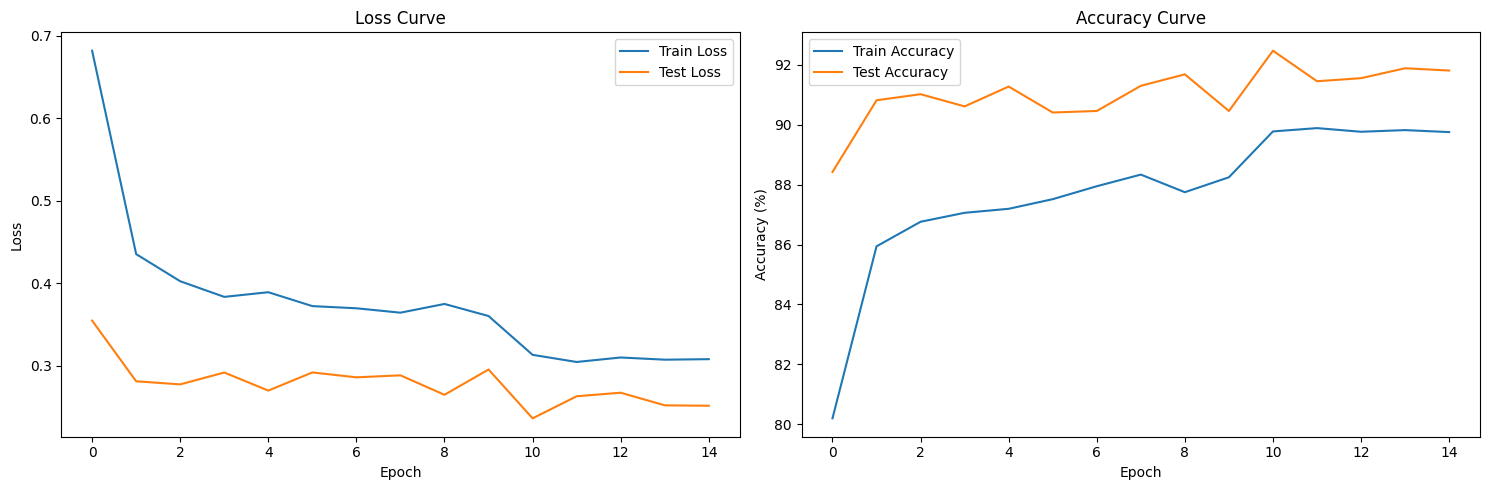

In [ ]:
# 学習曲線の可視化
plt.figure(figsize=(15, 5))

# === 損失関数の推移グラフ ===
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss') # 訓練データに対する損失の時系列プロット
plt.plot(test_losses, label='Test Loss')    # テストデータに対する損失の時系列プロット
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# === 正解率の推移グラフ ===
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy') # 訓練データに対する正解率の時系列プロット
plt.plot(test_accs, label='Test Accuracy')    # テストデータに対する正解率の時系列プロット
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
# plt.savefig(f'learning_curve.png', dpi=300, bbox_inches='tight') # ファイルとして保存
plt.show()


## 予測例の表示

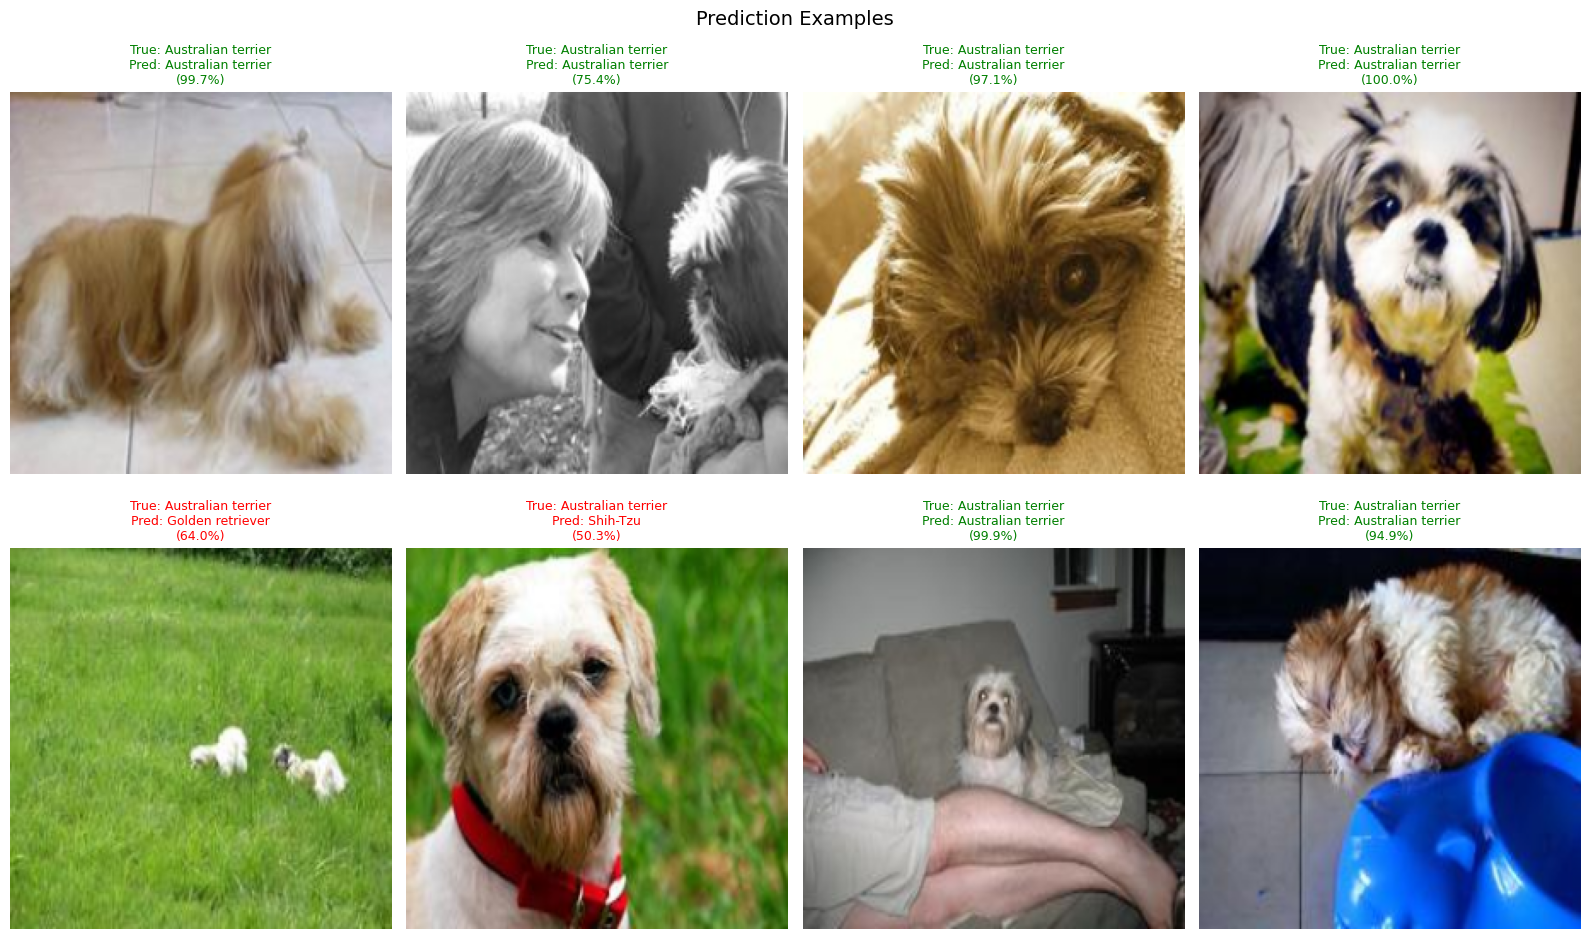

In [ ]:
# 予測例の表示
def show_high_res_predictions(model, test_loader, device, class_names, num_images=8):
    """
    学習済みモデルの予測結果を視覚的に表示する関数

    モデルの性能を直感的に理解するため、実際の画像と予測結果を並べて表示。
    正解・不正解を色分けし、予測確信度も併せて表示する。

    Args:
        model: 学習済みのニューラルネットワークモデル
        test_loader: テスト用データローダー
        device: 計算デバイス（CPU or GPU）
        class_names: クラス名のリスト
        num_images: 表示する画像数（デフォルト：8枚）
    """
    model.eval() # モデルを評価モードに設定

    # テストデータから1バッチを取得
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device) # GPU/CPUに転送

    # モデルによる予測実行
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # === 可視化 ===
    plt.figure(figsize=(16, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i+1)

        img = images[i].cpu() # GPU→CPUへ転送

        # 画像の逆正規化(ImageNet正規化の逆変換)により表示可能な形式に復元
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)

        # 画像の表示
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

        # ラベル情報
        true_label = class_names[labels[i]] if labels[i] < len(class_names) else f'Class {labels[i]}'
        pred_label = class_names[predicted[i]] if predicted[i] < len(class_names) else f'Class {predicted[i]}'
        # 予測確信度の計算
        confidence = probabilities[i][predicted[i]] * 100

        # 正確時は緑，不正解時は赤でタイトルを表示
        color = 'green' if labels[i] == predicted[i] else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)',
                 color=color, fontsize=9)
        plt.axis('off')

    plt.suptitle(f'Prediction Examples', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# 予測例の表示
show_high_res_predictions(model, test_loader, device, class_names)